<a href="https://colab.research.google.com/github/ashishagg70/GANText2Image/blob/master/Text2Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
#!gdown --id 1UQNd2OsbuuW5QSfc6-78e0heJk3F3FeL
#!gdown --id 14a90ceynctKczgase-iVbS8ZbwcTZSOT
#!gdown --id 1d1Cfsz1BcdWE_b4eF8KG6tSa0efsKLZ0
!gdown --id 19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG

Downloading...
From: https://drive.google.com/uc?id=1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
To: /content/img_align_celeba.zip
1.44GB [00:21, 67.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG
To: /content/list_attr_celeba.csv.zip
2.12MB [00:00, 65.9MB/s]


In [ ]:
!unzip img_align_celeba.zip
!unzip list_attr_celeba.csv.zip
#!unzip list_bbox_celeba.csv.zip
#!unzip list_eval_partition.csv.zip
#!unzip list_landmarks_align_celeba.csv.zip

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 extracting: img_align_celeba/197622.jpg  
 extracting: img_align_celeba/197623.jpg  
 ex

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision import datasets, transforms
from PIL import Image
from torchvision.transforms import ToPILImage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

cuda


In [ ]:
image_dir='./img_align_celeba/'
features=40
z_features = 20
batch = 1000

In [ ]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [ ]:
images = []
for i in range(1,batch):
  filename = "{}{:06d}.jpg".format(image_dir,i)
  image = Image.open(filename)
  x = transform(image).numpy()
  images.append(x)

In [ ]:
list_attr_celeba = pd.read_csv("list_attr_celeba.csv")
print(list_attr_celeba.head())
attributes = list_attr_celeba.iloc[:,1:].values
print(len(attributes),len(attributes[0]))
#list_bbox_celeba = pd.read_csv("list_bbox_celeba.csv")
#list_eval_partition = pd.read_csv("list_eval_partition.csv")
#list_landmarks_align_celeba = pd.read_csv("list_landmarks_align_celeba.csv")

#print(list_bbox_celeba.head())
#print(list_eval_partition.head())
#print(list_landmarks_align_celeba.head())

     image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]
202599 40


In [ ]:
def collate_fn(data):
  imgs = list(map(images.__getitem__,data))
  attrs= list(map(attributes.__getitem__,data))
  l = len(data)
  
  imgs = torch.tensor(imgs).to(device)
  attrs = torch.tensor(attrs)
  z= torch.randn((l,z_features))
  attrs = torch.hstack((attrs,z))
  attrs = attrs.to(device)
  return imgs,attrs


In [ ]:
train_loader = torch.utils.data.DataLoader(
    range(batch-1),
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [ ]:
class nn_G(nn.Module):
    def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(features+z_features, 8192)

      self.conv1 = nn.ConvTranspose2d(512,256,4,stride=2, padding=1)
      self.bnorm1 = nn.BatchNorm2d(256)

      self.conv2 = nn.ConvTranspose2d(256,128,4,stride=2, padding=1)
      self.bnorm2 = nn.BatchNorm2d(128)
      self.conv3 = nn.ConvTranspose2d(128,64,4,stride=2, padding=1)
      self.bnorm3 = nn.BatchNorm2d(64)
      self.conv4 = nn.ConvTranspose2d(64,3,4,stride=2, padding=1)
      #self.bnorm4 = nn.BatchNorm2d(3)
      


    def forward(self,x):
      #print("gen start",x.shape)

      x = self.linear1(x)
      #print("lin",x.shape)

      x = x.reshape((len(x),512,4,4))
      #print("reshape",x.shape)

      x = self.conv1(x)
      x = self.bnorm1(x)
      x = nn.LeakyReLU()(x)
      #print("conv1",x.shape)

      x = self.conv2(x)
      x = self.bnorm2(x)
      x = nn.LeakyReLU()(x)
      #print("conv2",x.shape)

      x = self.conv3(x)
      x = self.bnorm3(x)
      x = nn.LeakyReLU()(x)
      #print("conv3",x.shape)

      x = self.conv4(x)
      #print("conv4",x.shape)

      #x = self.bnorm2(x)
      x = nn.Tanh()(x)
      #print("tanh",x.shape)


      return x


In [ ]:
class nn_D(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,64,4,stride=2, padding=1)
      self.bnorm1 = nn.BatchNorm2d(64)

      self.conv2 = nn.Conv2d(64,128,4,stride=2, padding=1)
      self.bnorm2 = nn.BatchNorm2d(128)
      self.conv3 = nn.Conv2d(128,256,4,stride=2, padding=1)
      self.bnorm3 = nn.BatchNorm2d(256)
      self.conv4 = nn.Conv2d(256,512,4,stride=2, padding=1)
      self.bnorm4 = nn.BatchNorm2d(512)
      
      self.conv5 = nn.Conv2d(512+z_features+features,512+z_features+features,4,stride=2, padding=1)

      self.linear = nn.Linear((512+z_features+features)*4,1)

    def forward(self,x,t):
      #print("dis start",x.shape, t.shape)

      x = self.conv1(x)
      #print("conv1",x.shape)
      x = self.bnorm1(x)
      x = nn.LeakyReLU()(x)

      x = self.conv2(x)
      #print("conv2",x.shape)
      x = self.bnorm2(x)
      x = nn.LeakyReLU()(x)
      
      x = self.conv3(x)
      #print("conv3",x.shape)
      x = self.bnorm3(x)
      x = nn.LeakyReLU()(x)
      

      x = self.conv4(x)
      #print("conv4",x.shape)
      x = self.bnorm4(x)
      x = nn.LeakyReLU()(x)

      t = torch.unsqueeze(t,dim=2)
      t = torch.unsqueeze(t,dim=3)
      t = torch.repeat_interleave(t,4,2)
      t = torch.repeat_interleave(t,4,3)
      #print("stack t",t.shape)

      x = torch.cat((x,t),dim=1)
      #print("merge",x.shape)

      x = self.conv5(x)
      #print("conv5",x.shape)

      sizes = x.size()
      x = x.view(sizes[0], sizes[1] * sizes[2] * sizes[3])
      #print("flatten",x.shape)

      x = self.linear(x)
      #print("len",x.shape)


      x = nn.Sigmoid()(x)
      #print("final",x.shape)
      x=x.squeeze(1)

      return x


In [ ]:
nn_Gen = nn_G().to(device)
nn_Dis = nn_D().to(device)

In [ ]:

epochs = 30

learning_rate = 0.0001

optimizer_gen = torch.optim.Adam(nn_Gen.parameters(),lr=learning_rate,betas=(0.5,0.5))

optimizer_dis = torch.optim.Adam(nn_Dis.parameters(),lr=learning_rate*2,betas=(0.5,0.5))

criterion = nn.BCELoss()

real_label = 1
fake_label = 0


In [ ]:

for epoch in range(epochs):
    for batch_idx, _data in enumerate(train_loader):
      _imgs, _attrs = _data
      optimizer_dis.zero_grad()
      out_real = nn_Dis(_imgs,_attrs)
      r = np.random.random()
      l = len(_attrs)
      real_tensor = torch.tensor([real_label]*l,dtype=torch.float).to(device)
      fake_tensor = torch.tensor([fake_label]*l,dtype=torch.float).to(device)

      if(r>0.25):
        loss_real = criterion(out_real,real_tensor)
      else:
        loss_real = criterion(out_real,fake_tensor)
      loss_real.backward()

      out_fake = nn_Dis(nn_Gen(_attrs),_attrs)
      if(r>0.25):
        loss_fake = criterion(out_fake,real_tensor)
      else:
        loss_fake = criterion(out_fake,fake_tensor)
      loss_fake.backward()
      optimizer_dis.step()
      
      optimizer_gen.zero_grad()
      out_fake2 = nn_Dis(nn_Gen(_attrs),_attrs)
      loss_gen = criterion(out_fake2,real_tensor)
      loss_gen.backward()
      optimizer_gen.step()
    print("{}, out_real={},out_fake={},out_fake2={},loss_real={},loss_fake={},loss_gen={}".format(epoch, out_real.mean().item(),out_fake.mean().item(),out_fake2.mean().item(),loss_real.item(),loss_fake.item(),loss_gen.item()))

    gen_z= torch.rand(z_features)
    gen_attr = torch.tensor(attributes[100])
    gen_input = torch.cat((gen_attr,gen_z)).squeeze(0).to(device)
    gen = nn_Gen(gen_input)
    gen = gen.squeeze(0)
    img = ToPILImage()(x.cpu())
    img.save('./gen/{}.jpg'.format(epoch))



0, out_real=0.8940971493721008,out_fake=0.9633698463439941,out_fake2=0.6111979484558105,loss_real=2.6189868450164795,loss_fake=3.6589927673339844,loss_gen=0.5421528816223145
1, out_real=0.9963905215263367,out_fake=0.9990578889846802,out_fake2=0.9659374356269836,loss_real=5.970663070678711,loss_fake=7.272111415863037,loss_gen=0.03504155948758125
2, out_real=0.9682978987693787,out_fake=0.9948849678039551,out_fake2=0.9989666938781738,loss_real=0.03285983204841614,loss_fake=0.005135331302881241,loss_gen=0.001034083659760654
3, out_real=0.12000340968370438,out_fake=0.0905415490269661,out_fake2=0.020326388999819756,loss_real=0.13073867559432983,loss_fake=0.09737803786993027,loss_gen=4.116086959838867
4, out_real=0.37804466485977173,out_fake=0.5590806007385254,out_fake2=0.7227798700332642,loss_real=1.0333038568496704,loss_fake=0.6103371381759644,loss_gen=0.33433079719543457
5, out_real=0.6856260895729065,out_fake=0.7539230585098267,out_fake2=0.6676984429359436,loss_real=0.3896358609199524,los

In [ ]:
z= torch.rand(z_features)
attr = torch.tensor(attributes[10])
gen_input = torch.cat((attr,z)).unsqueeze(0).to(device)
x = nn_Gen(gen_input)
x = x.squeeze(0)

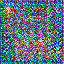

In [ ]:

img = ToPILImage()(x.cpu())
img

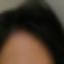

In [ ]:
img = ToPILImage()(images[100].cpu())
img

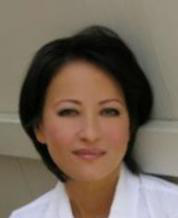

In [ ]:
filename = "{}{:06d}.jpg".format(image_dir,101)
image = Image.open(filename)
image

torch.Size([3, 64, 64])


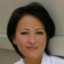

In [ ]:
x = transform2(image)
print(x.shape)
img = ToPILImage()(x.cpu())
img

In [ ]:
transform2 = transforms.Compose([transforms.Resize(64),
                                 transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [ ]:
x = transforms.functional.to_tensor(image)
print(x.shape)
img = ToPILImage()(x.cpu())
img

In [ ]:
pd.set_option("display.max_columns",None)
print(list_attr_celeba.head(11))


      image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0   000001.jpg                -1                1           1   
1   000002.jpg                -1               -1          -1   
2   000003.jpg                -1               -1          -1   
3   000004.jpg                -1               -1           1   
4   000005.jpg                -1                1           1   
5   000006.jpg                -1                1           1   
6   000007.jpg                 1               -1           1   
7   000008.jpg                 1                1          -1   
8   000009.jpg                -1                1           1   
9   000010.jpg                -1               -1           1   
10  000011.jpg                -1               -1           1   

    Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  \
0                -1    -1     -1        -1        -1          -1          -1   
1                 1    -1     -1        -1         1       

References:\
1. https://www.kaggle.com/jessicali9530/celeba-dataset?select=list_attr_celeba.csv \
2. 